In [1]:
# Import necessary libraries
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the CSV file
df = pd.read_csv("/kaggle/input/tbx11k-simplified/tbx11k-simplified/data.csv")

# Set the path to the folder containing the images
image_dir = '/kaggle/input/tbx11k-simplified/tbx11k-simplified/images'


2025-06-29 07:34:57.599393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751182497.621057      84 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751182497.627699      84 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Function to load and preprocess images
def load_image(fname, img_size=(128, 128)):
    img_path = os.path.join(image_dir, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    img = cv2.resize(img, img_size)  # Resize the image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Load the images and prepare labels for the three tasks
images = []
tb_labels = []
bbox_labels = []
severity_labels = []
sources = []

for i, row in df.iterrows():
    img = load_image(row['fname'])
    if img is not None:  # Only add the image if it was loaded successfully
        images.append(img)

        # Labels for binary classification (TB or not)
        if row['target'] == 'tb':
            tb_labels.append(1)
        else:
            tb_labels.append(0)

        # Labels for localization of affected areas (if no infection, bounding box is [0, 0, 0, 0])
        if row['bbox'] != 'none':
            bbox = eval(row['bbox'])
            bbox_labels.append([bbox['xmin'], bbox['ymin'], bbox['width'], bbox['height']])
        else:
            bbox_labels.append([0, 0, 0, 0])

        # Labels for infection severity (active TB / latent TB / no TB)
        if row['tb_type'] == 'active_tb':
            severity_labels.append(2)  # Active TB
        elif row['tb_type'] == 'latent_tb':
            severity_labels.append(1)  # Latent TB
        else:
            severity_labels.append(0)  # No TB

        # Save the source of each image (assuming the CSV has a column named 'source')
        sources.append(row['source'])


In [3]:
# Convert lists to NumPy arrays
X = np.expand_dims(np.array(images), axis=-1)  # Add channel dimension (grayscale)
y_tb = to_categorical(tb_labels, num_classes=2)  # Binary classification labels (TB or not)
y_bbox = np.array(bbox_labels)  # Bounding box localization labels
y_severity = to_categorical(severity_labels, num_classes=3)  # Severity labels (none, latent_tb, active_tb)
sources = np.array(sources)

# Filter images into training and validation sets based on 'source' column
X_train = X[sources == 'train']
X_val = X[sources == 'val']

y_tb_train = y_tb[sources == 'train']
y_tb_val = y_tb[sources == 'val']

y_bbox_train = y_bbox[sources == 'train']
y_bbox_val = y_bbox[sources == 'val']

y_severity_train = y_severity[sources == 'train']
y_severity_val = y_severity[sources == 'val']

# Define model architecture for the three tasks
input_img = Input(shape=(128, 128, 1))  # Input shape for grayscale images

# Convolutional Neural Network block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Branch for binary classification (TB detection)
tb_output = Dense(2, activation='softmax', name='tb_output')(x)

# Branch for localization (bounding box regression)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)

# Branch for severity classification (3 categories)
severity_output = Dense(3, activation='softmax', name='severity_output')(x)

# Create the model
model = Model(inputs=input_img, outputs=[tb_output, bbox_output, severity_output])

# Compile the model with different loss functions and metrics for each output
model.compile(optimizer='adam',
              loss={
                  'tb_output': 'binary_crossentropy',
                  'bbox_output': 'mean_squared_error',
                  'severity_output': 'categorical_crossentropy'
              },
              metrics={
                  'tb_output': ['accuracy', 'AUC'],
                  'bbox_output': 'mse',
                  'severity_output': 'accuracy'
              })


I0000 00:00:1751182701.790454      84 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751182701.791264      84 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# Train the model
history = model.fit(
    X_train,
    {
        'tb_output': y_tb_train,            # Labels for TB classification
        'bbox_output': y_bbox_train,        # Labels for bounding box regression
        'severity_output': y_severity_train # Labels for TB severity classification
    },
    validation_data=(X_val, {
        'tb_output': y_tb_val,
        'bbox_output': y_bbox_val,
        'severity_output': y_severity_val
    }),
    epochs=10,       # Number of training epochs
    batch_size=64    # Number of samples per training batch
)


Epoch 1/10


I0000 00:00:1751182708.895982     119 service.cc:148] XLA service 0x7f00fc010240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751182708.897796     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751182708.897816     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751182709.412457     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/108 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - bbox_output_loss: 4691.6582 - bbox_output_mse: 4691.6582 - loss: 4693.2002 - severity_output_accuracy: 0.5307 - severity_output_loss: 0.9318 - tb_output_AUC: 0.8174 - tb_output_accuracy: 0.7947 - tb_output_loss: 0.6102

I0000 00:00:1751182714.920307     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - bbox_output_loss: 2959.7283 - bbox_output_mse: 2959.7485 - loss: 2961.1895 - severity_output_accuracy: 0.8066 - severity_output_loss: 0.8849 - tb_output_AUC: 0.8663 - tb_output_accuracy: 0.8338 - tb_output_loss: 0.5561 - val_bbox_output_loss: 2743.8909 - val_bbox_output_mse: 2661.1860 - val_loss: 2661.9543 - val_severity_output_accuracy: 0.8491 - val_severity_output_loss: 0.4096 - val_tb_output_AUC: 0.9300 - val_tb_output_accuracy: 0.8790 - val_tb_output_loss: 0.3794
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - bbox_output_loss: 1786.1401 - bbox_output_mse: 1786.1481 - loss: 1786.7821 - severity_output_accuracy: 0.9001 - severity_output_loss: 0.3948 - tb_output_AUC: 0.9595 - tb_output_accuracy: 0.9212 - tb_output_loss: 0.2395 - val_bbox_output_loss: 1954.9475 - val_bbox_output_mse: 1903.1984 - val_loss: 1903.8379 - val_severity_output_accuracy: 0.8958 - val_severity_output_loss: 0.4296 - val_tb_output_AUC: 0.9584 - val_tb_output_ac

In [5]:
print("Final X shape:", X.shape)  # Display the final shape of the input data array X


Final X shape: (8811, 128, 128, 1)


In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Save the model
model.save('/kaggle/working/model_tb.h5')


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


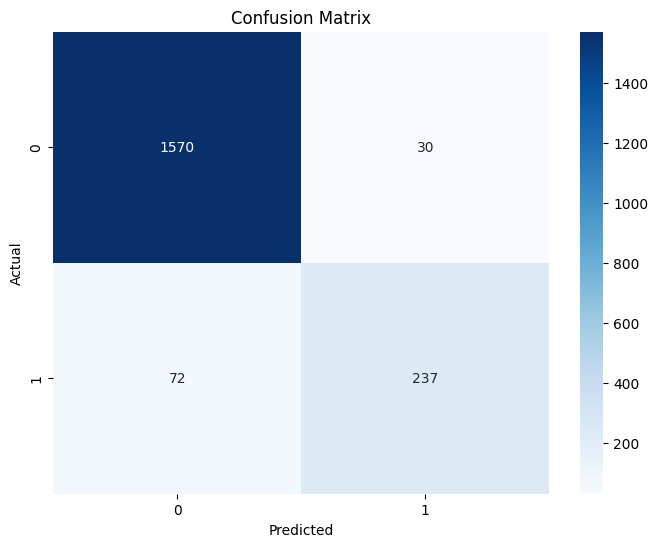

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions for the confusion matrix
y_pred = model.predict(X_val)[0]  # Get predictions from the 'tb_output' output
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels (0 or 1)
y_true_classes = np.argmax(y_tb_val, axis=1)  # Get the true class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


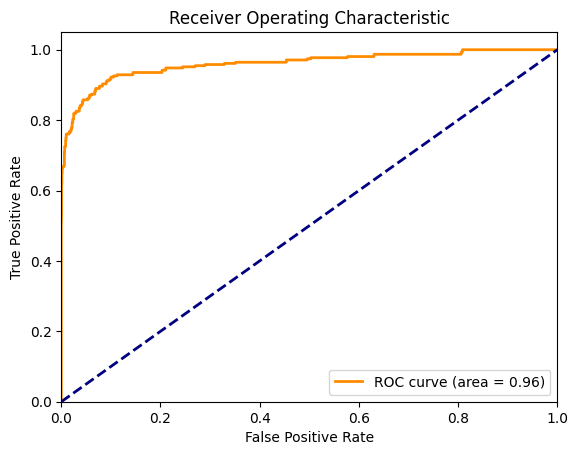

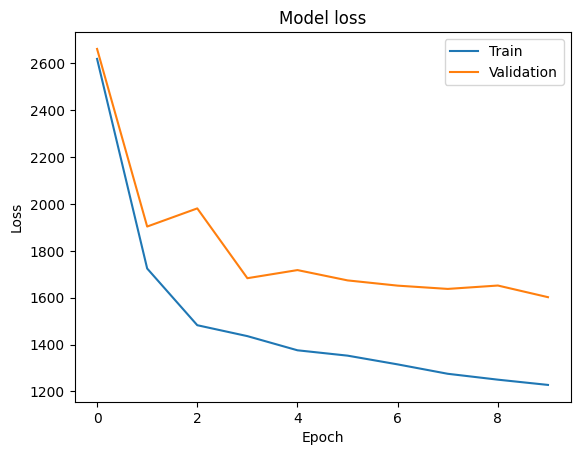

In [8]:
# Predictions for the ROC curve
y_pred_prob = model.predict(X_val)[0]  # Get predicted probabilities from the 'tb_output' output
fpr, tpr, thresholds = roc_curve(y_tb_val[:, 1], y_pred_prob[:, 1])  # Calculate ROC curve (for the positive class)
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot training vs. validation loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
import os
import csv
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the model
model = load_model('/kaggle/working//model_tb.h5')

# Directory containing the images
images_dir = '/kaggle/input/tbx11k-simplified/tbx11k-simplified/test'

# Create CSV file
csv_file = open('/kaggle/working/resultados_clasificacion.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['image_name', 'classification', 'localization', 'tb_type'])

# Process each image in the folder
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Make sure to process only image files
        img_path = os.path.join(images_dir, filename)

        # Load and preprocess the image
        img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)

        # Get predictions from the model
        tb_pred, bbox_pred, severity_pred = model.predict(img_array)

        # Classification (tb or no tb)
        tb_class = "tb" if tb_pred[0][1] > 0.5 else "no tb"

        # Localization (bounding box)
        if tb_class == "tb":
            bbox = {
                'xmin': bbox_pred[0][0],
                'ymin': bbox_pred[0][1],
                'width': bbox_pred[0][2],
                'height': bbox_pred[0][3]
            }
        else:
            bbox = "none"

        # Type of TB
        severity_classes = ["none", "latent_tb", "active_tb"]
        severity_class = severity_classes[np.argmax(severity_pred)]

        # Write results to CSV file
        csv_writer.writerow([filename, tb_class, bbox, severity_class])

# Close the CSV file
csv_file.close()

print("CSV file created successfully.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [12]:
model.input_shape  # or model.summary()

(None, 128, 128, 1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- METRICS FOR TB CLASSIFICATION ---
Accuracy TB: 0.9465688842325825
Precision TB: 0.8876404494382022
Recall TB: 0.7669902912621359
F1-Score TB: 0.8229166666666666

Classification Report for TB:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1600
           1       0.89      0.77      0.82       309

    accuracy                           0.95      1909
   macro avg       0.92      0.87      0.90      1909
weighted avg       0.95      0.95      0.94      1909


--- METRICS FOR BOUNDING BOX (Regression) ---
MSE Bounding Box: 1601.3922545663504

--- METRICS FOR SEVERITY CLASSIFICATION ---
Accuracy Severity: 0.9025667888947093
Precision Severity: 0.8980824801622826
Recall Severity: 0.9025667888947093
F1-Score Severity: 0.897877522503265

Classification Report for Severity:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1600
          

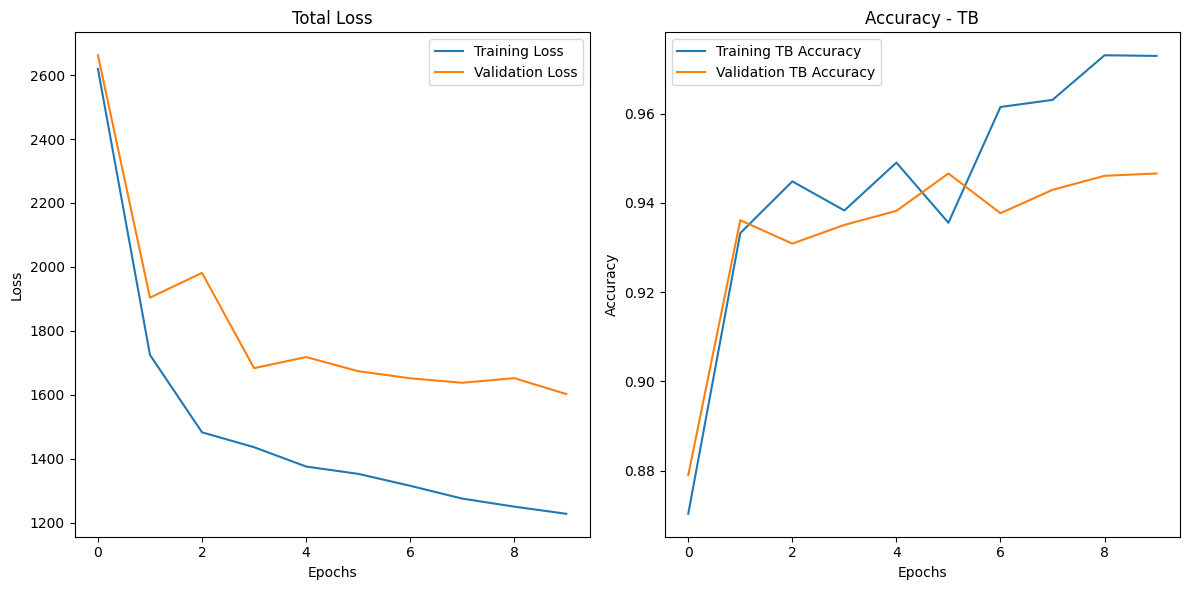

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt

# Predictions
preds = model.predict(X_val)
preds_tb = np.argmax(preds[0], axis=1)        # TB classification predictions
preds_bbox = preds[1]                         # Bounding box predictions
preds_severity = np.argmax(preds[2], axis=1)  # Severity classification predictions

# True values
true_tb = np.argmax(y_tb_val, axis=1)
true_bbox = y_bbox_val
true_severity = np.argmax(y_severity_val, axis=1)

### Metrics for TB (Binary Classification)
print("\n--- METRICS FOR TB CLASSIFICATION ---")
print("Accuracy TB:", accuracy_score(true_tb, preds_tb))
print("Precision TB:", precision_score(true_tb, preds_tb))
print("Recall TB:", recall_score(true_tb, preds_tb))
print("F1-Score TB:", f1_score(true_tb, preds_tb))

# Full classification report for TB
print("\nClassification Report for TB:\n", classification_report(true_tb, preds_tb))

### Metrics for Bounding Box (Regression)
print("\n--- METRICS FOR BOUNDING BOX (Regression) ---")
mse_bbox = mean_squared_error(true_bbox, preds_bbox)
print("MSE Bounding Box:", mse_bbox)

### Metrics for Severity (Multiclass Classification)
print("\n--- METRICS FOR SEVERITY CLASSIFICATION ---")
print("Accuracy Severity:", accuracy_score(true_severity, preds_severity))
print("Precision Severity:", precision_score(true_severity, preds_severity, average='weighted'))
print("Recall Severity:", recall_score(true_severity, preds_severity, average='weighted'))
print("F1-Score Severity:", f1_score(true_severity, preds_severity, average='weighted'))

# Full classification report for severity
print("\nClassification Report for Severity:\n", classification_report(true_severity, preds_severity))

### Plots of Loss and Metrics
# Training vs. Validation graphs
plt.figure(figsize=(12, 6))

# Total Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# TB Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['tb_output_accuracy'], label='Training TB Accuracy')
plt.plot(history.history['val_tb_output_accuracy'], label='Validation TB Accuracy')
plt.title('Accuracy - TB')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
